<a href="https://colab.research.google.com/github/Charles8745/gans-in-action/blob/master/gans_in_action_CH3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

print(f"Pythyon: {sys.version}")
print(f"Keras: {keras.__version__}")

Pythyon: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Keras: 3.8.0


In [3]:
# Hyperparameters
img_height = 28
img_width = 28
channel = 1
z_dim = 100 # Noise的向量長度
h_dim = 128 # Hidden layer維度
iterations = 20000
batch_size = 128
sample_interval = 1000

img_size = (img_width, img_height, channel)

In [4]:
# Build generator
def build_generator(img_size, z_dim):
  model = Sequential()

  model.add(Dense(h_dim, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01)) # 避免訓練時梯度消失
  model.add(Dense(28*28*1, activation='tanh')) # tanh輸出[-1,1]可以讓圖像更清晰

  model.add(Reshape(img_size))

  return model


In [5]:
# Build discriminator
def build_discriminator(img_size):
  model = Sequential()

  model.add(Flatten(input_shape = img_size))
  model.add(Dense(h_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid')) # Sigmoid輸出[0,1]

  return model

In [6]:
# Build Gan
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [7]:
# Compile: ge, D, G

# build ge
generator = build_generator(img_size, z_dim)

# compile D
discriminator = build_discriminator(img_size)
discriminator.compile(
    loss = 'binary_crossentropy', # 使用二元交叉熵，評估二元分類預測與實際的差距
    optimizer = Adam(),
    metrics = ['accuracy'])

# lock D when training generator
# discriminator.trainable = False # 書上這邊是錯的

# compile GAN
gan = build_gan(generator, discriminator)
gan.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Sample imgs 函式
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # sample noise
  z = np.random.normal(0,1,(image_grid_rows*image_grid_columns, z_dim))

  # generate imgs
  gen_imgs = generator.predict(z, verbose=0)

  # rescale
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set grid
  fig, axs = plt.subplots(
      image_grid_rows,
      image_grid_columns,
      figsize = (4,4),
      sharey=True,
      sharex=True
      )

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

In [9]:
# 編寫訓練程式

# 紀錄訓練過程
losses = []
accuracies = []
iter_ckpt = []

def train(iters, batch_size, sample_interval):
  # load mnist data
  (x_train,_), (_,_) = mnist.load_data()

  # data preprocess
  x_train = x_train/127.5 - 1.0 # 因為使用tanh
  x_train = np.expand_dims(x_train, axis=3)
  '''
  The original MNIST images are grayscale and have dimensions (number of images, height, width)
  . This line adds a channel dimension, making the shape (number of images, height, width, 1).
  '''

  real = np.ones((batch_size, 1)) # label
  fake = np.zeros((batch_size, 1))

  # train loop
  for iter in range(iters):
    '''
    Training D
    '''
    discriminator.trainable = True
    # get some real imgs
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    # generate some fake imgs
    z = np.random.normal(0,1, (batch_size,z_dim))
    gen_imgs = generator.predict(z, verbose=0)

    # train D
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    '''
    Training G
    '''
    discriminator.trainable = False # 要記得鎖discriminator
    # train GAN
    z = np.random.normal(0,1,(batch_size, z_dim))
    g_loss = gan.train_on_batch(z, real) # 訓練Generator時要讓圖的label接近1

    # sample
    if (iter+1) % sample_interval == 0:
      # save losses, accuracies, ckpt
      losses.append((d_loss, g_loss))
      accuracies.append(100.0*accuracy)
      iter_ckpt.append(iter+1)

      # print progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
        (iter + 1, d_loss, 100.0 * accuracy, g_loss))

      # sample fake img
      sample_images(generator)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1000 [D loss: 0.047198, acc.: 98.69%] [G loss: 4.821085]
2000 [D loss: 0.055806, acc.: 98.57%] [G loss: 4.734791]
3000 [D loss: 0.080373, acc.: 97.51%] [G loss: 4.761297]
4000 [D loss: 0.116649, acc.: 95.90%] [G loss: 4.661338]
5000 [D loss: 0.151632, acc.: 94.34%] [G loss: 4.494146]
6000 [D loss: 0.175194, acc.: 93.32%] [G loss: 4.395704]
7000 [D loss: 0.194595, acc.: 92.44%] [G loss: 4.277366]
8000 [D loss: 0.207975, acc.: 91.83%] [G loss: 4.196285]
9000 [D loss: 0.220261, acc.: 91.29%] [G loss: 4.150533]
10000 [D loss: 0.232441, acc.: 90.75%] [G loss: 4.097113]
11000 [D loss: 0.244373, acc.: 90.20%] [G loss: 4.025840]
12000 [D loss: 0.252877, acc.: 89.80%] [G loss: 3.964712]
13000 [D loss: 0.259420, acc.: 89.48%] [G loss: 3.919584]
14000 [D loss: 0.265244, acc.: 89.19%] [G loss: 3.874621]
15000 [D loss: 0.271670, acc.: 88.87%] [G loss: 3.828433]
16000 [D loss: 0.277837, acc.: 88.56%] [G loss: 3.778375]
17000 [D loss: 0.283130, acc.:

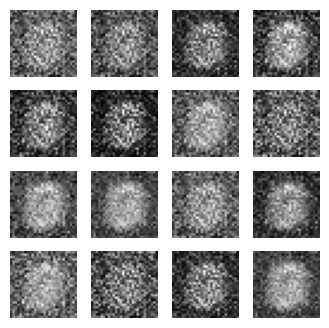

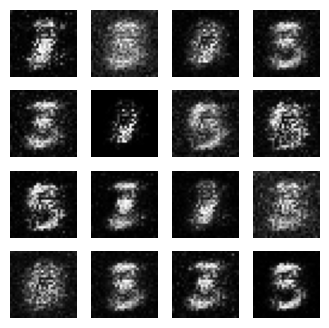

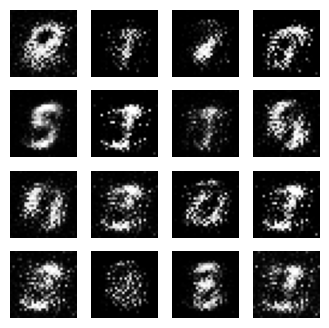

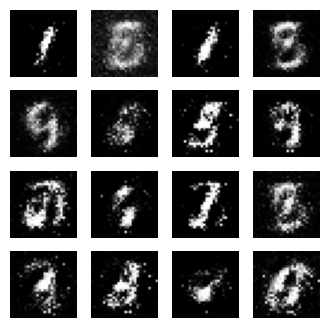

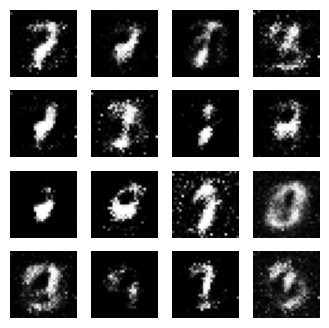

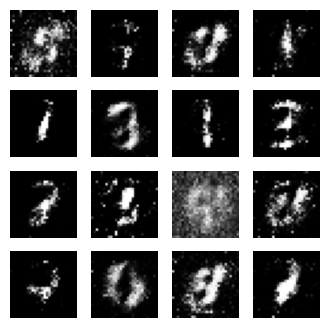

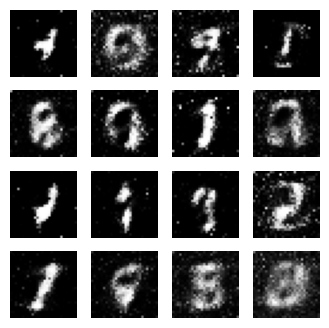

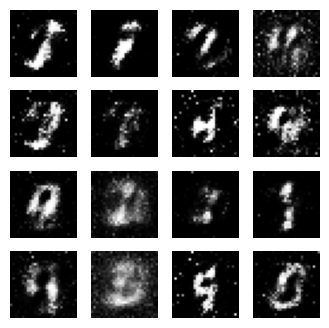

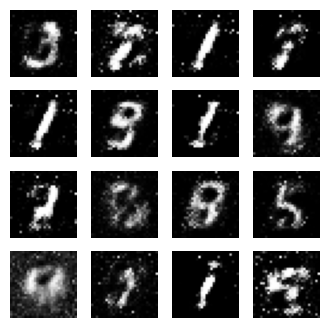

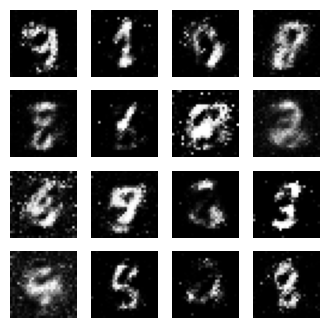

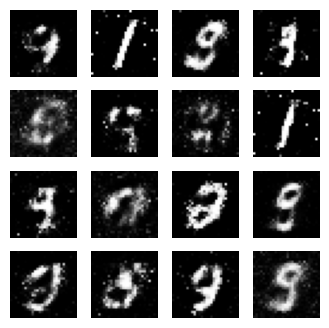

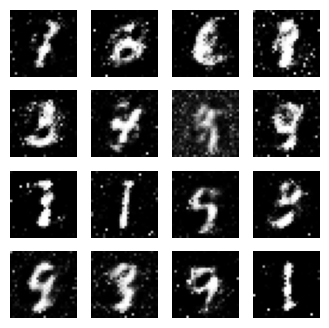

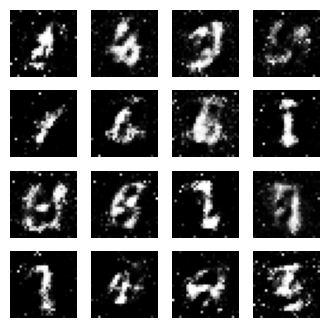

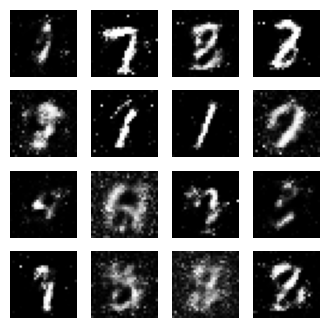

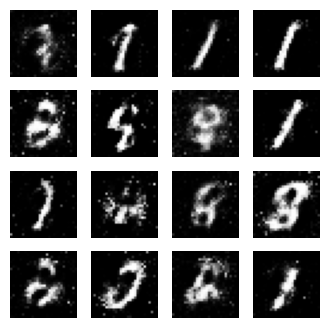

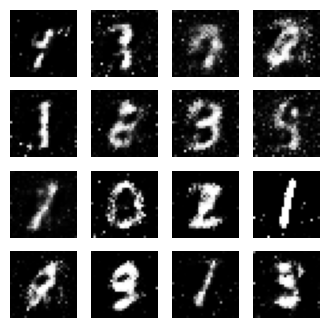

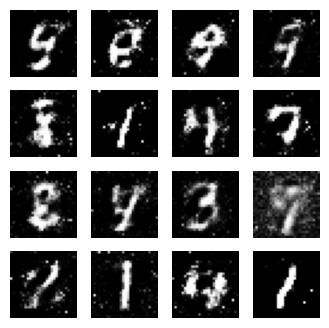

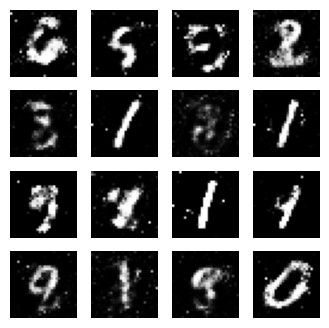

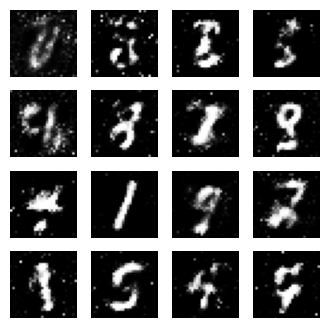

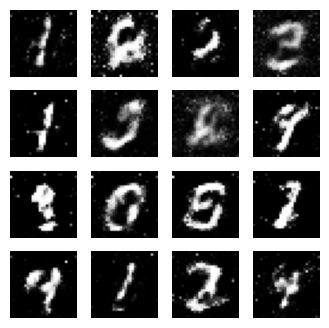

In [10]:
# Train
train(iterations, batch_size, sample_interval)


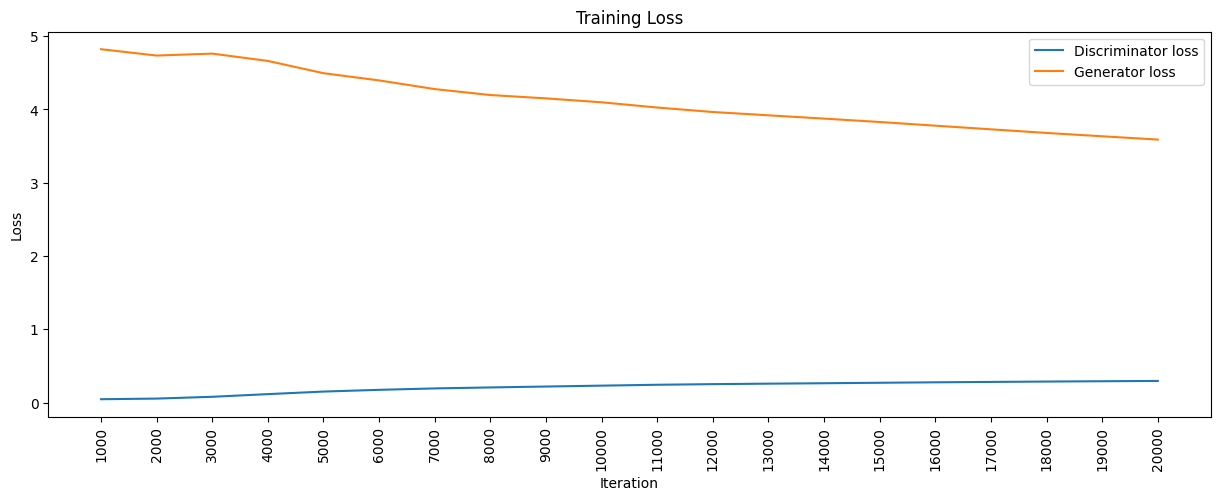

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iter_ckpt, losses.T[0], label="Discriminator loss")
plt.plot(iter_ckpt, losses.T[1], label="Generator loss")

plt.xticks(iter_ckpt, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

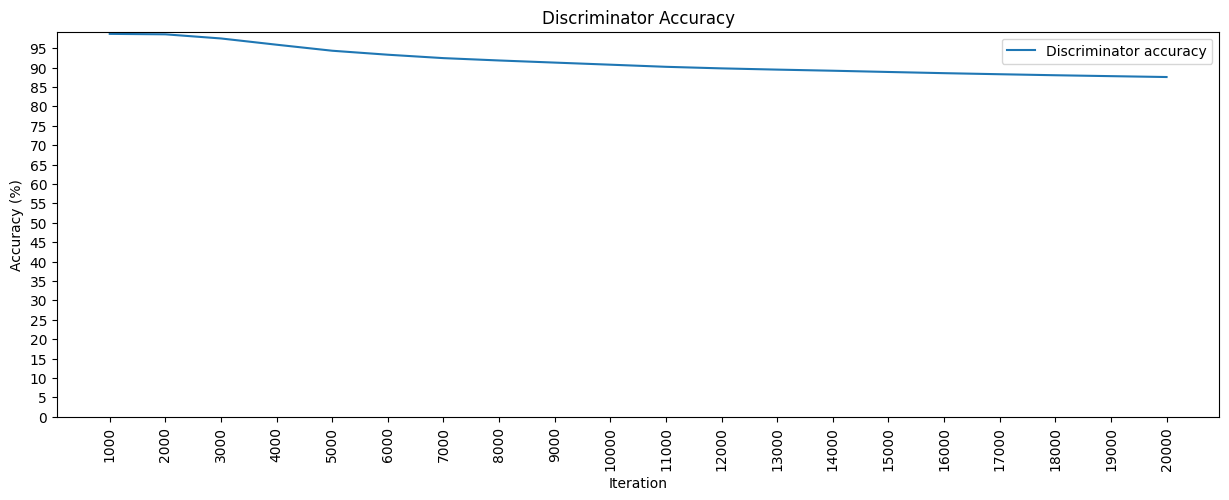

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iter_ckpt, accuracies, label="Discriminator accuracy")

plt.xticks(iter_ckpt, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()